In [22]:
# import packages
import sys
import math
import datetime
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load the data
df = pd.read_csv("../../DataSet/mnist_train.csv")

In [3]:
df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df.shape

(60000, 785)

In [5]:
# input and output features
X = df.iloc[:,1:].to_numpy() / 255
Y = df.iloc[:,0].to_numpy()

In [6]:
# Train and Test split
Xtrain, Xtest, Ytrain, Ytest = X[:-1000], X[-1000:], Y[:-1000], Y[-1000:]

In [7]:
# Shuffle the training data
Xtrain, Ytrain = shuffle(Xtrain, Ytrain)

In [8]:
def showPic(x,y):
    plt.title("Digit: "+str(y))
    plt.imshow(x.reshape(28,28))
    plt.show()

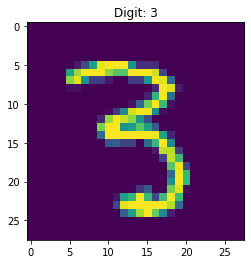

In [9]:
# Testing a PIC
id = 1
showPic(Xtrain[id], Ytrain[id])

In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [11]:
def tanh(z):
    return (np.exp(z)-np.exp(-z)) / (np.exp(z)+np.exp(-z))

In [12]:
def relu(z):
    return z*(z>0)

In [13]:
def softmax(z):
    return np.exp(z) / np.exp(z).sum(axis=1, keepdims=True)

In [14]:
def nonlinearDeri(z,activation):
    if activation=="sigmoid":
        return z*(1-z)
    if activation=="tanh":
        return (1-z**2)
    if activation=="relu":
        return (z>0)

In [15]:
def oneHotEncode(y):
    T = np.zeros((y.shape[0], np.unique(y).shape[0]))
    
    for i,val in enumerate(y):
        T[i,val] = 1
        
    return T

In [16]:
def cost(t,y):
    return -np.sum(t*np.log(y))

In [17]:
def predict(y):
    return np.argmax(y, axis=1)

In [18]:
def forward(X,T,hidden,activation,W,B,A,i,seed):
    D = X.shape[1]
    L = len(hidden)
    K = T.shape[1]
    np.random.seed(seed)
    
    for l in range(L+1):
        if l==0:
            if i==0:
                W[l] = np.random.randn(D,hidden[l])
                B[l] = np.random.randn(hidden[l])
            A[l] = activation(np.dot(X,W[l])+B[l])
        
        elif l==L:
            if i==0:
                W[l] = np.random.randn(hidden[l-1],K)
                B[l] = np.random.randn(K)
            A[l] = softmax(np.dot(A[l-1],W[l])+B[l])
            Y = A[l]
        
        else:
            if i==0:
                W[l] = np.random.randn(hidden[l-1],hidden[l])
                B[l] = np.random.randn(hidden[l])
            A[l] = activation(np.dot(A[l-1],W[l])+B[l])
    
    return W,B,A,Y

In [19]:
def backprop(X,T,Y,hidden,activation,lr,W,B,A):
    L = len(hidden)
    E,delta = {},{}
    
    # Error and Gradient Calculation
    for l in range(L,-1,-1):
        if l==L:
            E[l] = T-Y
            delta[l] = E[l] # softmax derivative
        
        else:
            E[l] = np.dot(delta[l+1],W[l+1].T)
            delta[l] = E[l]*nonlinearDeri(A[l], activation.__name__)
    
    # Weights update
    for l in range(L+1):
        if l==0:
            W[l] += lr*np.dot(X.T, delta[l])
            B[l] += lr*np.sum(delta[l], axis=0)
        else:
            W[l] += lr*np.dot(A[l-1].T, delta[l])
            B[l] += lr*np.sum(delta[l], axis=0)
            
    return W,B

In [20]:
def fit(X,T,Xtest,Ytest,hidden,activation,lr,iterations,batch_size,seed):
    N = X.shape[0]
    T = oneHotEncode(T)
    Ttest = oneHotEncode(Ytest)
    
    W,B,A = {},{},{}
    Ctrain, Ctest = [], []
    
    n_batches = math.ceil(N / batch_size)
    
    for i in range(iterations):
        for j in range(n_batches):
            start = batch_size*j
            end = batch_size*(j+1) if j<n_batches else N
        
            W, B, A, Y = forward(X[start:end],T[start:end],hidden,activation,W,B,A,i,seed)
            W, B = backprop(X[start:end],T[start:end],Y,hidden,activation,lr,W,B,A)
            _,_,_,Y_test = forward(Xtest,Ttest,hidden,activation,W,B,A,2,seed)

            sys.stdout.write("\nIteration: {} | Batch: {} | Training Cost: {} | Test Cost: {}".format(i+1,j+1, str(cost(T[start:end],Y))[:6], str(cost(Ttest,Y_test))[:6]))
            
        Ctrain.append(cost(T[start:end],Y))
        Ctest.append(cost(Ttest,Y_test))
        
    _,_,_,Y = forward(X,T,hidden,activation,W,B,A,2,seed) # Prediction for all training samples
    Yhat = predict(Y)
    Yhat_test = predict(Y_test)
    
    return Ctrain,Ctest,W,B,Yhat,Yhat_test

In [21]:
def accuracy(t,y):
    return np.mean(t==y)

In [ ]:
size = Xtrain.shape[0] # Full Batch
ctrain_full, ctest_full, w, b, Yhat, Yhat_test = fit(Xtrain,Ytrain,Xtest,Ytest,[100],sigmoid,lr=0.00001,iterations=50000,batch_size=size,seed=1)
print("\n\nTraining Accuracy: {}%".format(accuracy(Ytrain, Yhat)*100))
print("Testing Accuracy: {}%".format(accuracy(Ytest, Yhat_test)*100))


Iteration: 1 | Batch: 1 | Training Cost: 413349 | Test Cost: 5759.4
Iteration: 2 | Batch: 1 | Training Cost: 337018 | Test Cost: 5113.9
Iteration: 3 | Batch: 1 | Training Cost: 300735 | Test Cost: 4749.7
Iteration: 4 | Batch: 1 | Training Cost: 281555 | Test Cost: 4463.5
Iteration: 5 | Batch: 1 | Training Cost: 265593 | Test Cost: 4204.3
Iteration: 6 | Batch: 1 | Training Cost: 251103 | Test Cost: 3968.3
Iteration: 7 | Batch: 1 | Training Cost: 237954 | Test Cost: 3753.4
Iteration: 8 | Batch: 1 | Training Cost: 226029 | Test Cost: 3558.1
Iteration: 9 | Batch: 1 | Training Cost: 215211 | Test Cost: 3380.3
Iteration: 10 | Batch: 1 | Training Cost: 205386 | Test Cost: 3218.3
Iteration: 11 | Batch: 1 | Training Cost: 196448 | Test Cost: 3070.2
Iteration: 12 | Batch: 1 | Training Cost: 188296 | Test Cost: 2934.4
Iteration: 13 | Batch: 1 | Training Cost: 180843 | Test Cost: 2809.5
Iteration: 14 | Batch: 1 | Training Cost: 174011 | Test Cost: 2694.2
Iteration: 15 | Batch: 1 | Training Cost: 

## Full Gradient Descent (FGD)

In [ ]:
size=Xtrain.shap[0] # All the samples at once weight update happens

fgd_start_time = datetime.datetime.now()
ctrain_full, ctest_full, w, b, Yhat, Yhat_test = fit(Xtrain,Ytrain,Xtest,Ytest,[100],sigmoid,lr=0.00001,iterations=20000,batch_size=size,seed=1)
fgd_end_time = datetime.datetime.now()

print("\n\nTraining Accuracy: {}%".format(accuracy(Ytrain, Yhat)*100))
print("Testing Accuracy: {}%".format(accuracy(Ytest, Yhat_test)*100))
print("Time spent: ", fgd_end_time-fgd_start_time)

## Batch Gradient Descent (BGD)

In [ ]:
size=10000 # 10000 samples at a time weight update happens

bgd_start_time = datetime.datetime.now()
ctrain_batch, ctest_batch, w, b, Yhat, Yhat_test = fit(Xtrain,Ytrain,Xtest,Ytest,[100],sigmoid,lr=0.00001,iterations=20000,batch_size=size,seed=1)
bgd_end_time = datetime.datetime.now()

print("\n\nTraining Accuracy: {}%".format(accuracy(Ytrain, Yhat)*100))
print("Testing Accuracy: {}%".format(accuracy(Ytest, Yhat_test)*100))
print("Time spent: ", bgd_end_time-bgd_start_time)

## Stochastic Gradient Descent (SGD)

In [ ]:
size=1 # 1 sample at a time weight update happens

stock_start_time = datetime.datetime.now()
ctrain_stochastic, ctest_stochastic, w, b, Yhat, Yhat_test = fit(Xtrain,Ytrain,Xtest,Ytest,[100],sigmoid,lr=0.00001,iterations=20000,batch_size=size,seed=1)
stock_end_time = datetime.datetime.now()

print("\n\nTraining Accuracy: {}%".format(accuracy(Ytrain, Yhat)*100))
print("Testing Accuracy: {}%".format(accuracy(Ytest, Yhat_test)*100))
print("Time spent: ", stock_end_time-stock_start_time)

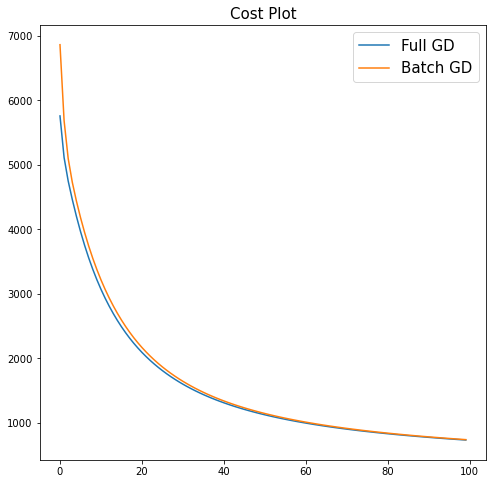

In [108]:
plt.figure(figsize=(8,8))
plt.title("Cost Plot", fontsize=15)
plt.plot(ctest_full, label="Full GD")
plt.plot(ctest_batch, label="Batch GD")
plt.legend(fontsize=15)
plt.show()